# Load data

In [1]:
import pandas as pd 

train = pd.read_csv('dataset/train.csv', index_col = 'id')
test = pd.read_csv('dataset/test.csv', index_col = 'id')
submission = pd.read_csv('dataset/sample_submission.csv', index_col = 'id')

# Feature Engineering 

## concat train/test

In [2]:
all_data = pd.concat([train, test], ignore_index = True)
all_data = all_data.drop('target', axis = 1)

all_features = all_data.columns 

## 명목형 피처 원-핫 인코딩

In [3]:
from sklearn.preprocessing import OneHotEncoder 

# 명목형 피처 추출 
cat_features = [feature for feature in all_features if 'cat' in feature]

onehot_encoder = OneHotEncoder()

# 인코딩
encoded_cat_matrix = onehot_encoder.fit_transform(all_data[cat_features])

encoded_cat_matrix

<1488028x184 sparse matrix of type '<class 'numpy.float64'>'
	with 20832392 stored elements in Compressed Sparse Row format>

## 파생 피처 추가

### 한 데이터가 가진 결측값 개수

In [4]:
all_data['num_missing'] = (all_data == -1).sum(axis = 1)

원-핫 인코딩을 수행한 명목형 피처, calc 분류의 피처를 제외한 나머지 피처를 **remaining_features**에 저장

In [5]:
remaining_features = [feature for feature in all_features if ('cat' not in feature and \
                                                             'calc' not in feature)]

remaining_features.append('num_missing')

### ind 분류의 피처 탐색

모든 ind 피처 값을 연결해서 새로운 피처 생성 
- ps_ind_01~ps_ind_03값이 각각 2, 2, 5라면 2_2_5_와 같은 값을 반환
> max_ind라는 변수명으로 생성

In [6]:
[feature for feature in all_features if 'ind' in feature]

['ps_ind_01',
 'ps_ind_02_cat',
 'ps_ind_03',
 'ps_ind_04_cat',
 'ps_ind_05_cat',
 'ps_ind_06_bin',
 'ps_ind_07_bin',
 'ps_ind_08_bin',
 'ps_ind_09_bin',
 'ps_ind_10_bin',
 'ps_ind_11_bin',
 'ps_ind_12_bin',
 'ps_ind_13_bin',
 'ps_ind_14',
 'ps_ind_15',
 'ps_ind_16_bin',
 'ps_ind_17_bin',
 'ps_ind_18_bin']

In [7]:
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True 

for ind_feature in ind_features : 
    if is_first_feature : 
        all_data['mix_ind'] = all_data[ind_feature].astype(str) + '_'
        is_first_feature = False
        
    else :
        all_data['mix_ind'] = all_data['mix_ind'] + all_data[ind_feature].astype(str) + '_'

In [8]:
all_data['mix_ind'] 

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

### 명목형 피처의 고유값별 개수를 새로운 피처로 추가

In [9]:
cat_count_features = [] 

for feature in cat_features + ['mix_ind'] : 
    val_counts_dict = all_data[feature].value_counts().to_dict()
    all_data[f'{feature}_count'] = all_data[feature].apply(lambda x: val_counts_dict[x])
    
    cat_count_features.append(f'{feature}_count')

In [10]:
# 추가된 변수 목록
cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

## 필요없는 피처 제거 

### 새롭게 만든 피처 목록

- encoded_cat_matrix : 원-핫 인코딩된 명목형 피처
- ramaining_features : 명목형 피처와 calc 분ㄹ의 피처를 제외한 피처들 
- cat_count_features : mix_ind를 포함한 명목형 피처의 고유값별 개수 파생 피처

In [11]:
from scipy import sparse 

# 필요없는 피처들 
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 
                 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

# remaining_featurem, cat_count_features에서 drop_feature를 제거 
all_data_remaining = all_data[remaining_features + cat_count_features].drop(drop_features, 
                                                                            axis = 1)

# 데이터 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data_remaining),
                               encoded_cat_matrix], format = 'csr')

In [12]:
all_data['mix_ind']

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

## split data

In [13]:
num_train = len(train)

X = all_data_sprs[:num_train]
X_test = all_data_sprs[num_train:]

y = train['target'].values

## 정규화 지니계수 계산 함수 구현

In [14]:
def eval_gini(y_true, y_pred) : 
    # 실제값과 예측값의 크기가 서로 같은지 확인(다르면 에러 발생)
    assert y_true.shape == y_pred.shape
    
    # 데이터 개수
    n_samples = y_true.shape[0]
    # 대각선 값 
    L_mid = np.linspace(1/n_samples, 1, n_samples)
    
    # 1. 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()]
    L_pred = np.cumsum(pred_order) / np.sum(pred_order)
    G_pred = np.sum(L_mid - L_pred)
    
    # 2. 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()]
    L_true = np.cumsum(true_order) / np.sum(true_order)
    G_true = np.sum(L_mid - L_true)
    
    # 정규화된 지니계수
    return G_pred / G_true

**모델 훈련 시 검증 파라미터에 전달하기 위한 함수**

In [15]:
# LGBM용 gini() 함수
def gini(preds, dtrain) : 
    labels = dtrain.get_label()
     # 마지막 True는 값이 클수록 성능이 좋은지의 여부
    return 'gini', eval_gini(labels, preds), True

# 하이퍼 파라미터 최적화

## dataset 

In [16]:
import lightgbm as lgb 
from sklearn.model_selection import train_test_split 

X_train, X_valid, y_train, y_valid = \
train_test_split(X, y, test_size = 0.2, random_state = 0)

# 베이지안 최적화용 데이터셋 
bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\ProgramData\Anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


하이퍼 파라미터의 범위를 지정, 값을 고정할 파라미터는 fixed_params에 저장 

In [17]:
param_bounds = {'num_leaves' : (30, 40), 
                'lambda_l1' : (0.7, 0.9),
                'lambda_l2' : (0.9, 1),
                'feature_fraction' : (0.6, 0.7),
                'bagging_fraction' : (0.6, 0.9),
                'min_child_samples' : (6, 10), 
                'min_child_weight' : (10, 40)}

fixed_params = {'objective' : 'binary' ,
                'learning_rate' : 0.005,
                'bagging_freq' : 1, 
                'force_row_wise' : True,
                'random_state' : 1991}

**베이지안 최적화용 평가지표 계산 함수**

In [18]:
def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight) : 
    
    # 베이지안 최적화를 수행할 하이퍼 파라미터 
    params = {'num_leaves' : int(round(num_leaves)), 
                'lambda_l1' : lambda_l1,
                'lambda_l2' : lambda_l2,
                'feature_fraction' : feature_fraction,
                'bagging_fraction' : bagging_fraction,
                'min_child_samples' : int(round(min_child_samples)), 
                'min_child_weight' : min_child_weight,
                'feature_pre_filter' : False}
    
    # 고정된 하이퍼 파라미터
    params.update(fixed_params)
    
    print('Hyper parameter : ', params)
    
    # LGBM 훈련 
    lgb_model = lgb.train(params = params,
                          train_set = bayes_dtrain,
                          num_boost_round = 2500, 
                          valid_sets = bayes_dvalid,
                          feval = gini, 
                          early_stopping_rounds = 300,
                          verbose_eval = False)
    
    # 검증 데이터로 예측 수행 
    preds = lgb_model.predict(X_valid)
    
    # 지니계수
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

## 최적화 수행 

In [19]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f = eval_function, 
                                 pbounds = param_bounds,
                                 random_state = 0)

In [20]:
optimizer.maximize(init_points = 3, n_iter = 6)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
Hyper parameter :  {'num_leaves': 34, 'lambda_l1': 0.8205526752143287, 'lambda_l2': 0.9544883182996897, 'feature_fraction': 0.6715189366372419, 'bagging_fraction': 0.7646440511781974, 'min_child_samples': 8, 'min_child_weight': 29.376823391999682, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 1, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Info] Number of positive: 17383, number of negative: 458786
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036506 -> initscore=-3.273091
[LightGBM] [Info] Start training from score -3.273091
지니계수 : 0.2855811556220905

|  1        |  0.2856   |  0.

지니계수 : 0.28396673100103603

|  9        |  0.284    |  0.9      |  0.7      |  0.7      |  1.0      |  10.0     |  33.56    |  36.32    |


## 결과

In [21]:
max_params = optimizer.max['params']
max_params

{'bagging_fraction': 0.6213108174593661,
 'feature_fraction': 0.608712929970154,
 'lambda_l1': 0.7040436794880651,
 'lambda_l2': 0.9832619845547939,
 'min_child_samples': 9.112627003799401,
 'min_child_weight': 36.10036444740457,
 'num_leaves': 39.78618342232764}

In [22]:
# 정수형 하이퍼파라미터 변환 
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))

In [23]:
# 고정된 하이퍼파라미트 추가
max_params.update(fixed_params)
max_params

{'bagging_fraction': 0.6213108174593661,
 'feature_fraction': 0.608712929970154,
 'lambda_l1': 0.7040436794880651,
 'lambda_l2': 0.9832619845547939,
 'min_child_samples': 9,
 'min_child_weight': 36.10036444740457,
 'num_leaves': 40,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 1,
 'force_row_wise': True,
 'random_state': 1991}

# 모델 훈련 및 검증 

In [27]:
from sklearn.model_selection import StratifiedKFold

# 층화 K-Fold 교차 검증기 생성
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1991)

# OOF -> 검증 데이터
oof_val_preds = np.zeros(X.shape[0])

# OOF -> 테스트 데이터
oof_test_preds = np.zeros(X_test.shape[0])

# OOF 훈련, 예측 
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)) :
    # 각 폴드 구분
    print('#'*40, f'Fold {idx+1} / Fold {folds.n_splits}' ,'#'*40)
    
    # Split data 
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # LGBM dataset 
    dtrain = lgb.Dataset(X_train, y_train)
    dvalid = lgb.Dataset(X_valid, y_valid)
    
    # LGBM training 
    lgb_model = lgb.train(params = max_params, 
                          train_set = dtrain, 
                          num_boost_round = 2500,
                          valid_sets = dvalid,
                          feval = gini,
                          early_stopping_rounds = 300,
                          verbose_eval = 100)
    
    # OOF prediction using test data 
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    
    # OOF prediction using valid data for evaluate performance of model 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # normalized gini coefficient for pred_proba for valid data 
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    
    print(f'Fold {idx+1} Gini Coef. : {gini_score}\n')

######################################## Fold 1 / Fold 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Total Bins 1554
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Training until validation scores don't improve for 300 rounds
[100]	valid_0's binary_logloss: 0.154239	valid_0's gini: 0.270944
[200]	valid_0's binary_logloss: 0.153176	valid_0's gini: 0.275764
[300]	valid_0's binary_logloss: 0.152584	valid_0's gini: 0.279501
[400]	valid_0's binary_logloss: 0.152222	valid_0's gini: 0.282893
[500]	valid_0's binary_logloss: 0.151986	valid_0's gini: 0.286058
[600]	valid_0's binary_logloss: 0.151824	valid_0's gini: 0.288805
[700]	valid_0's binary_logloss: 0.151712	valid_0's gini: 0.290719
[800]	valid_0's binary_logloss: 0.151622	va

[2100]	valid_0's binary_logloss: 0.151799	valid_0's gini: 0.280516
Early stopping, best iteration is:
[1852]	valid_0's binary_logloss: 0.15179	valid_0's gini: 0.280514
Fold 4 Gini Coef. : 0.2805136229288192

######################################## Fold 5 / Fold 5 ########################################
[LightGBM] [Info] Number of positive: 17355, number of negative: 458815
[LightGBM] [Info] Total Bins 1558
[LightGBM] [Info] Number of data points in the train set: 476170, number of used features: 217
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274766
[LightGBM] [Info] Start training from score -3.274766
Training until validation scores don't improve for 300 rounds
[100]	valid_0's binary_logloss: 0.15439	valid_0's gini: 0.26681
[200]	valid_0's binary_logloss: 0.15338	valid_0's gini: 0.272186
[300]	valid_0's binary_logloss: 0.152821	valid_0's gini: 0.275897
[400]	valid_0's binary_logloss: 0.1525	valid_0's gini: 0.278734
[500]	valid_0's binary_logloss: 0.1522

In [28]:
print(f'OOF valid data Gini Coef. : {eval_gini(y, oof_val_preds)}')

OOF valid data Gini Coef. : 0.2889651000887542


# 예측 및 결과 제출

In [29]:
submission['target'] = oof_test_preds
submission.to_csv('submission_lgb.csv')

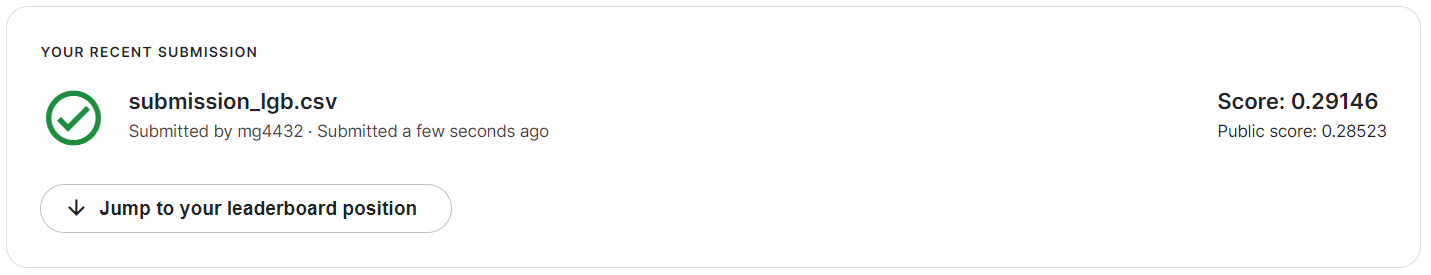

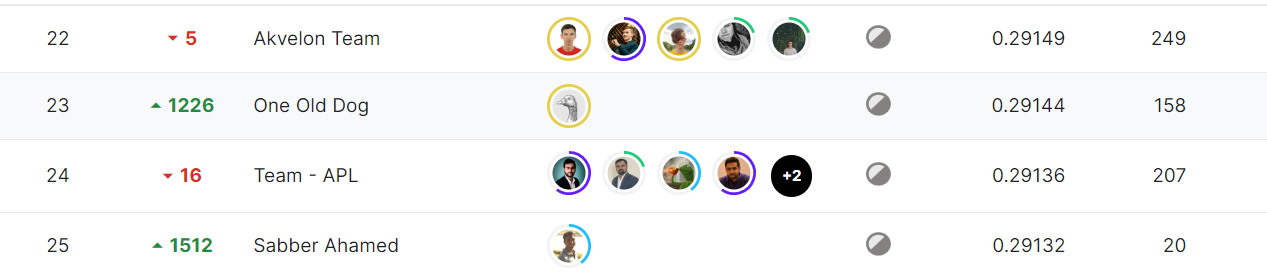